In [1]:
# Mengimpor modul yang diperlukan dari TensorFlow dan Keras untuk membangun dan melatih jaringan saraf
from tensorflow.keras.preprocessing import image  # Modul untuk preprocessing gambar
from tensorflow.keras.models import load_model  # Modul untuk memuat model yang telah dilatih sebelumnya
import os  # Modul untuk berinteraksi dengan sistem operasi, digunakan untuk manipulasi file
import numpy as np  # Modul untuk operasi numerik
import tensorflow as tf  # Perpustakaan TensorFlow
from tensorflow.keras.models import Model  # API Fungsional untuk membangun model Keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # Layer untuk membangun jaringan saraf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Modul untuk preprocessing dan augmentasi data gambar
from tensorflow.keras.applications import EfficientNetV2B0  # Model EfficientNetV2B0 yang telah dilatih sebelumnya
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input  # Fungsi untuk preprocessing data input untuk EfficientNetV2B0
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Metrik untuk evaluasi model
import seaborn as sns  # Perpustakaan visualisasi untuk membuat grafik statistik yang menarik dan informatif
import matplotlib.pyplot as plt  # Modul untuk membuat visualisasi statis, animasi, dan interaktif

In [2]:
# Mengimpor modul 'drive' dari pustaka 'google.colab' yang diperlukan untuk mengakses Google Drive
from google.colab import drive

# Mengaitkan Google Drive dengan sesi Colab dan memberikan izin akses untuk membaca dan menulis ke Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/DatasetMRIAD/dataset_224_fix/train'
test_dir = '/content/drive/MyDrive/DatasetMRIAD/dataset_224_fix/test'
val_dir = '/content/drive/MyDrive/DatasetMRIAD/dataset_224_fix/val'

Train set:
NonDemented=128
VeryMildDemented=128
MildDemented=128
ModerateDemented=128
SevereDemented=128
Test set:
NonDemented=16
VeryMildDemented=16
MildDemented=16
ModerateDemented=16
SevereDemented=16
Validation set:
NonDemented=16
VeryMildDemented=16
MildDemented=16
ModerateDemented=16
SevereDemented=16


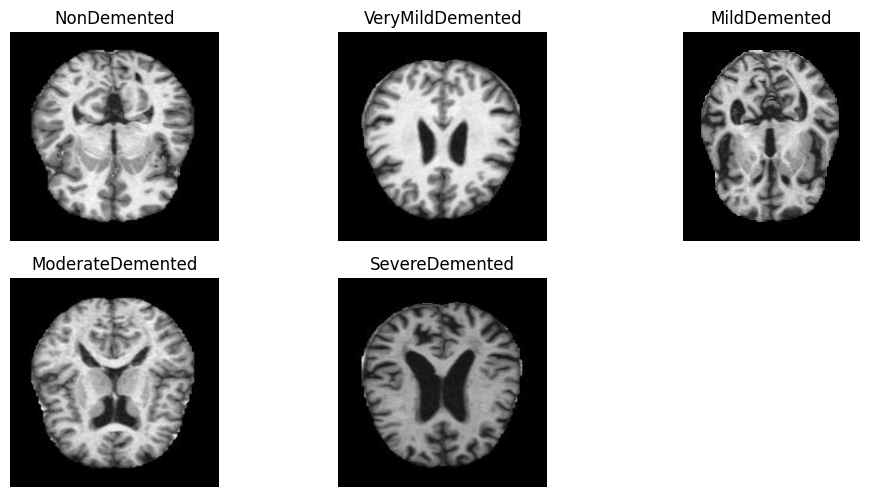

In [4]:
import os
import matplotlib.pyplot as plt

# Direktori utama dataset
base_dir = '/content/drive/MyDrive/DatasetMRIAD/dataset_224_fix/'

# Daftar nama kelas
classes = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented', 'SevereDemented']

# Menampilkan jumlah gambar dalam setiap kelas pada dataset train
print("Train set:\n========================================")
for class_name in classes:
    num_images = len(os.listdir(os.path.join(base_dir, 'train', class_name)))
    print(f"{class_name}={num_images}")

# Menampilkan jumlah gambar dalam setiap kelas pada dataset test
print("Test set:\n========================================")
for class_name in classes:
    num_images = len(os.listdir(os.path.join(base_dir, 'test', class_name)))
    print(f"{class_name}={num_images}")

# Menampilkan jumlah gambar dalam setiap kelas pada dataset validation
print("Validation set:\n========================================")
for class_name in classes:
    num_images = len(os.listdir(os.path.join(base_dir, 'val', class_name)))
    print(f"{class_name}={num_images}")

# Menampilkan contoh gambar dari setiap kelas
plt.figure(figsize=(10, 10))

for idx, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(base_dir, 'test', class_name)
    class_images = os.listdir(class_dir)[:1]  # Ambil 1 contoh gambar dari setiap kelas
    for i, image_name in enumerate(class_images, start=1):
        plt.subplot(4, 3, idx + i - 1)
        img = plt.imread(os.path.join(class_dir, image_name))
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# Menentukan bentuk masukan
input_shape = (224, 224, 3)

from keras.applications import EfficientNetV2B0

base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)


24274472/24274472 [==============================] - 0s 0us/step


In [6]:
# Memasukkan output dari base_model ke dalam variabel x
x = base_model.output

# Menambahkan layer GlobalAveragePooling2D untuk meratakan output menjadi vektor satu dimensi
x = GlobalAveragePooling2D()(x)

# Menambahkan layer Dense dengan 128 neuron dan fungsi aktivasi ReLU
x = Dense(128, activation='relu')(x)

# Menambahkan layer Dropout untuk mencegah overfitting
x = Dropout(0.5)(x)  # Dropout rate 0.5 berarti 50% dari neuron akan dinonaktifkan secara acak

# Menambahkan layer Dense dengan 5 neuron (sesuai dengan jumlah kelas) dan fungsi aktivasi softmax
predictions = Dense(5, activation='softmax')(x)

# Membentuk model dengan menghubungkan input dari base_model ke output dari layer predictions
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
# Compile model
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# Define data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=input_shape[:2],
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=input_shape[:2],
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=input_shape[:2],
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 640 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 80 images belonging to 5 classes.


In [9]:
# Menampilkan ringkasan dari arsitektur model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]']   

In [10]:
# Melatih model dengan data latih dari train_generator
import time

# Waktu awal
start_time = time.time()

history = model.fit(
    train_generator,  # Generator untuk data latih
    steps_per_epoch=len(train_generator),  # Jumlah langkah per epoch, dihitung dari panjang generator
    epochs=100,  # Jumlah epoch (iterasi lengkap atas dataset)
    validation_data=val_generator,  # Data validasi yang digunakan untuk mengevaluasi kinerja model
    validation_steps=len(val_generator)  # Jumlah langkah per epoch untuk validasi, dihitung dari panjang generator
)

end_time = time.time()

Epoch 1/100
20/20 [==============================] - 225s 11s/step - loss: 1.6125 - accuracy: 0.2688 - val_loss: 1.3787 - val_accuracy: 0.6000
Epoch 2/100
20/20 [==============================] - 3s 155ms/step - loss: 1.3725 - accuracy: 0.4391 - val_loss: 1.1592 - val_accuracy: 0.7375
Epoch 3/100
20/20 [==============================] - 3s 162ms/step - loss: 1.1698 - accuracy: 0.5719 - val_loss: 1.0016 - val_accuracy: 0.7750
Epoch 4/100
20/20 [==============================] - 4s 186ms/step - loss: 1.0374 - accuracy: 0.6031 - val_loss: 0.8942 - val_accuracy: 0.8250
Epoch 5/100
20/20 [==============================] - 3s 155ms/step - loss: 0.9581 - accuracy: 0.6406 - val_loss: 0.8073 - val_accuracy: 0.8000
Epoch 6/100
20/20 [==============================] - 3s 149ms/step - loss: 0.9088 - accuracy: 0.6656 - val_loss: 0.7435 - val_accuracy: 0.8500
Epoch 7/100
20/20 [==============================] - 4s 174ms/step - loss: 0.8435 - accuracy: 0.6812 - val_loss: 0.6952 - val_accuracy: 0.8625

In [11]:
# Hitung selisih waktu dalam detik
training_time_seconds = end_time - start_time

# Konversi ke menit
training_time_minutes = training_time_seconds / 60

print("Waktu pelatihan model:", training_time_minutes, "menit")

Waktu pelatihan model: 10.600482054551442 menit


In [12]:
# Menyimpan model dengan format .hdf5
model.save("Model_EfficientNetV2B0_100Epoch(0.001)lr.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Figure size 640x480 with 0 Axes>

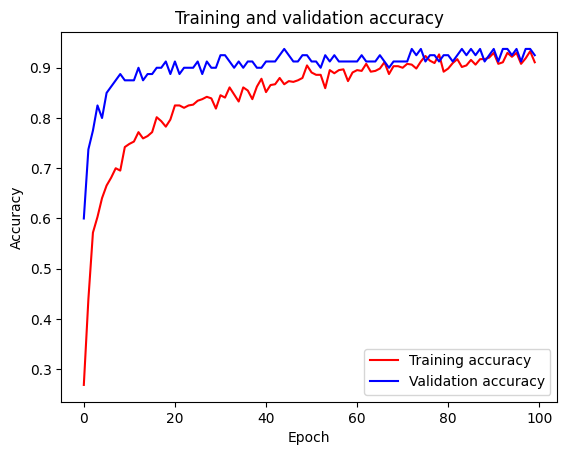

<Figure size 640x480 with 0 Axes>

In [13]:
# Mengambil nilai akurasi pelatihan dan validasi dari history
acc = history.history['accuracy']  # Akurasi pelatihan pada setiap epoch
val_acc = history.history['val_accuracy']  # Akurasi validasi pada setiap epoch

# Menentukan jumlah epoch
epochs = range(len(acc))  # Jumlah epoch

# Plot grafik akurasi pelatihan dan validasi terhadap epoch
plt.plot(epochs, acc, 'r', label='Training accuracy')  # Plot akurasi pelatihan
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')  # Plot akurasi validasi
plt.title('Training and validation accuracy')  # Judul grafik
plt.xlabel('Epoch')  # Label sumbu X (epoch)
plt.ylabel('Accuracy')  # Label sumbu Y (akurasi)
plt.legend()  # Menampilkan legenda
plt.figure()  # Menampilkan gambar grafik baru


<Figure size 640x480 with 0 Axes>

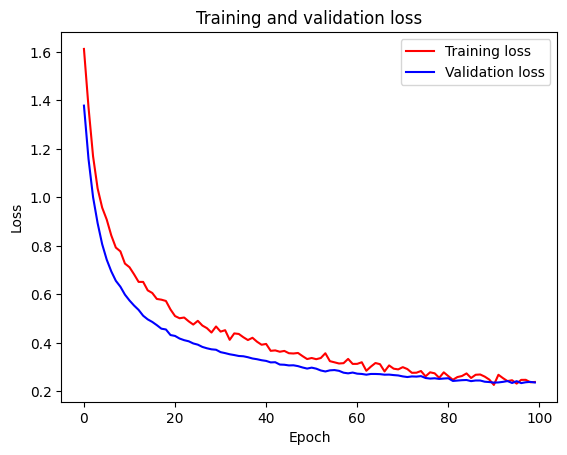

<Figure size 640x480 with 0 Axes>

In [14]:
# Mengambil nilai loss pelatihan dan validasi dari history
loss = history.history['loss']  # Loss pelatihan pada setiap epoch
val_loss = history.history['val_loss']  # Loss validasi pada setiap epoch

# Menentukan jumlah epoch
epochs = range(len(loss))  # Jumlah epoch

# Plot grafik loss pelatihan dan validasi terhadap epoch
plt.plot(epochs, loss, 'r', label='Training loss')  # Plot loss pelatihan
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # Plot loss validasi
plt.title('Training and validation loss')  # Judul grafik
plt.xlabel('Epoch')  # Label sumbu X (epoch)
plt.ylabel('Loss')  # Label sumbu Y (loss)
plt.legend()  # Menampilkan legenda
plt.figure()  # Menampilkan gambar grafik baru


In [15]:
# Evaluasi model menggunakan data latih (train_generator) dan mencetak akurasi pelatihan
evaluation = model.evaluate(train_generator)  # Melakukan evaluasi model menggunakan data latih
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")  # Mencetak akurasi pelatihan dalam persen

# Evaluasi model menggunakan data uji (test_generator) dan mencetak akurasi pengujian
evaluation = model.evaluate(test_generator)  # Melakukan evaluasi model menggunakan data uji
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")  # Mencetak akurasi pengujian dalam persen

# Evaluasi model menggunakan data uji (test_generator) dan mencetak akurasi pengujian
evaluation = model.evaluate(val_generator)  # Melakukan evaluasi model menggunakan data uji
print(f"Validation Accuracy: {evaluation[1] * 100:.2f}%")  # Mencetak akurasi pengujian dalam persen

20/20 [==============================] - 3s 136ms/step - loss: 0.1508 - accuracy: 0.9609
Train Accuracy: 96.09%
3/3 [==============================] - 17s 9s/step - loss: 0.2167 - accuracy: 0.9625
Test Accuracy: 96.25%
3/3 [==============================] - 0s 91ms/step - loss: 0.2370 - accuracy: 0.9250
Validation Accuracy: 92.50%


In [16]:
# Mengevaluasi model menggunakan data generator uji (test_generator)
model.evaluate(test_generator)

# Mengevaluasi model menggunakan data generator validasi (test_generator)
model.evaluate(val_generator)

3/3 [==============================] - 0s 89ms/step - loss: 0.2370 - accuracy: 0.9250


[0.23695941269397736, 0.925000011920929]

In [17]:
preds = model.predict_generator(generator=test_generator)  # Memprediksi probabilitas kelas menggunakan generator data uji
labels = 1 * (preds > 0.5)  # Mengonversi probabilitas menjadi kelas biner (0 atau 1) dengan threshold 0.5
# Mengambil data akurasi dan loss dari history
train_acc = history.history['accuracy']  # Akurasi pelatihan dari history
val_acc = history.history['val_accuracy']  # Akurasi validasi dari history
train_loss = history.history['loss']  # Loss pelatihan dari history
val_loss = history.history['val_loss']  # Loss validasi dari history

<ipython-input-17-0fe9d6fda485>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(generator=test_generator)  # Memprediksi probabilitas kelas menggunakan generator data uji


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Menggunakan model untuk membuat prediksi pada data test
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
# Mengambil kelas dengan nilai probabilitas tertinggi sebagai prediksi
y_pred = np.argmax(pred, axis=1)
y_true = test_generator.classes

pd.DataFrame(classification_report(test_generator.classes, y_pred, output_dict=True))

3/3 [==============================] - 0s 99ms/step


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,0.941176,0.9375,0.941176,0.9625,0.963971,0.963971
recall,0.937500,0.937500,1.000000,0.9375,1.000000,0.9625,0.962500,0.962500
f1-score,0.967742,0.967742,0.969697,0.9375,0.969697,0.9625,0.962476,0.962476
support,16.000000,16.000000,16.000000,16.0000,16.000000,0.9625,80.000000,80.000000


3/3 [==============================] - 0s 103ms/step


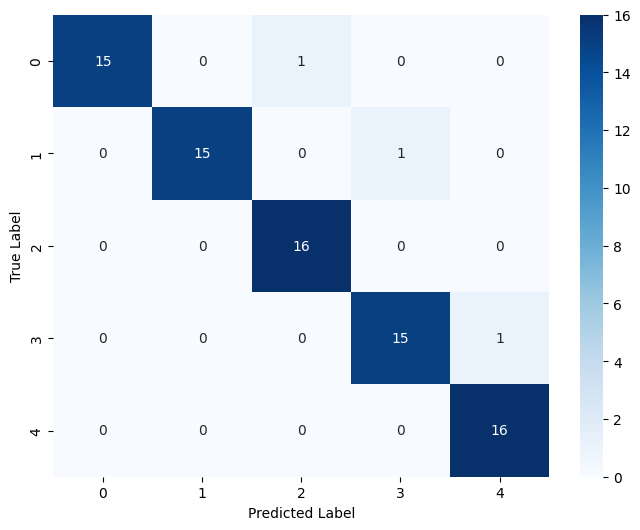

In [19]:
# Menggunakan model untuk membuat prediksi pada data test
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(pred, axis=1)
y_true = test_generator.classes


# Membuat confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

3/3 [==============================] - 0s 114ms/step
Overall Accuracy: 0.9625


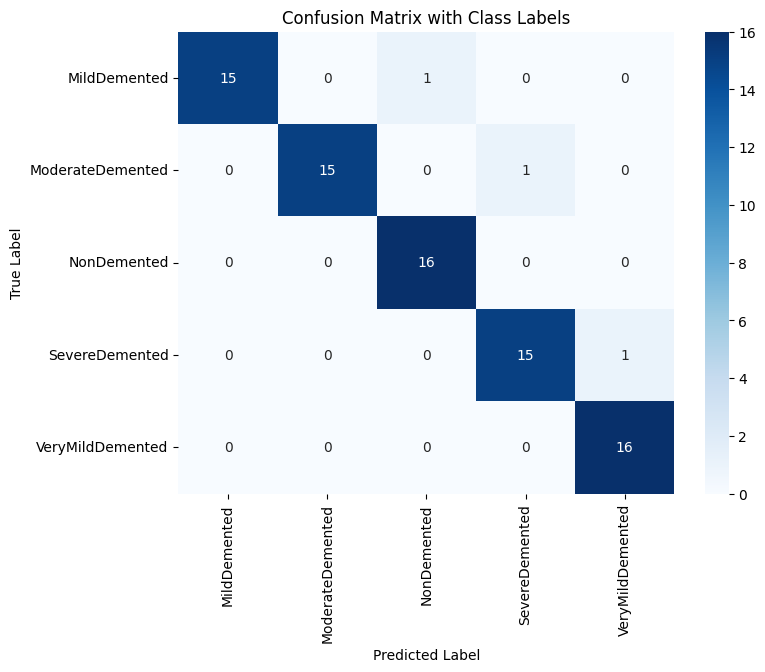

                  precision    recall  f1-score   support

    MildDemented       1.00      0.94      0.97        16
ModerateDemented       1.00      0.94      0.97        16
     NonDemented       0.94      1.00      0.97        16
  SevereDemented       0.94      0.94      0.94        16
VeryMildDemented       0.94      1.00      0.97        16

        accuracy                           0.96        80
       macro avg       0.96      0.96      0.96        80
    weighted avg       0.96      0.96      0.96        80



In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_generator is already defined and configured

# Extract class labels directly from the test generator
# This assumes that the classes attribute is accessible and correctly ordered
class_labels = list(test_generator.class_indices.keys())

# Predict class probabilities using the test generator
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert probabilities to predicted class indices
y_pred = np.argmax(pred, axis=1)

# Actual class labels from the test generator
y_true = test_generator.classes

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print('Overall Accuracy:', accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Class Labels')
plt.show()

# Generate and print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


In [22]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Menggunakan model untuk membuat prediksi pada data test
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
# Mengambil kelas dengan nilai probabilitas tertinggi sebagai prediksi
y_pred = np.argmax(pred, axis=1)
y_true = test_generator.classes

# Hitung akurasi keseluruhan
accuracy = accuracy_score(y_true, y_pred)
print('Overall Accuracy:', accuracy)

# Menggunakan model untuk membuat prediksi pada data test
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Mengambil kelas dengan nilai probabilitas tertinggi sebagai prediksi
y_pred_classes = np.argmax(pred, axis=1)
y_true = test_generator.classes

# Hitung akurasi
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy)

# Hitung presisi
precision = precision_score(y_true, y_pred, average='macro')
print('Precision:', precision)

# Hitung recall
recall = recall_score(y_true, y_pred, average='macro')
print('Recall:', recall)

# Hitung F1-score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1-score:', f1)

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

3/3 [==============================] - 0s 129ms/step
Overall Accuracy: 0.9625
3/3 [==============================] - 0s 150ms/step
Accuracy: 0.9625
Precision: 0.9639705882352942
Recall: 0.9625
F1-score: 0.9624755620723363
Confusion Matrix:
[[15  0  1  0  0]
 [ 0 15  0  1  0]
 [ 0  0 16  0  0]
 [ 0  0  0 15  1]
 [ 0  0  0  0 16]]


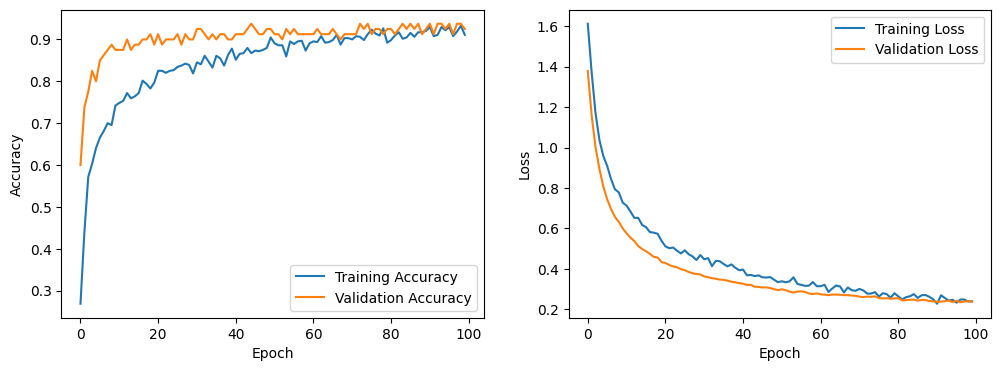

In [24]:
# Membuat plot learning curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()